In [15]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('canadian_hist_data.csv')

# Print the first 5 rows
print(df.head())


   Unnamed: 0          citation citation2 dataset  year  \
0           0  (1877) 1 SCR 110       NaN     SCC  1877   
1           1  (1877) 1 SCR 114       NaN     SCC  1877   
2           2  (1877) 1 SCR 117       NaN     SCC  1877   
3           3  (1877) 1 SCR 145       NaN     SCC  1877   
4           4  (1877) 1 SCR 235       NaN     SCC  1877   

                                                name language document_date  \
0  Boak et al. v. The Merchant's Marine Insurance...       en    1877-01-23   
1                                 Smyth v. McDougall       en    1877-02-01   
2                             The Queen v. Laliberté       en    1877-02-03   
3                        Brassard et al. v. Langevin       en    1877-02-28   
4  Johnstone v. The Minister & Trustees of St. An...       en    1877-06-28   

                                          source_url scraped_timestamp  \
0  https://decisions.scc-csc.ca/scc-csc/scc-csc/e...        2022-08-31   
1  https://decisions.s

In [2]:
print(len(df))

15707


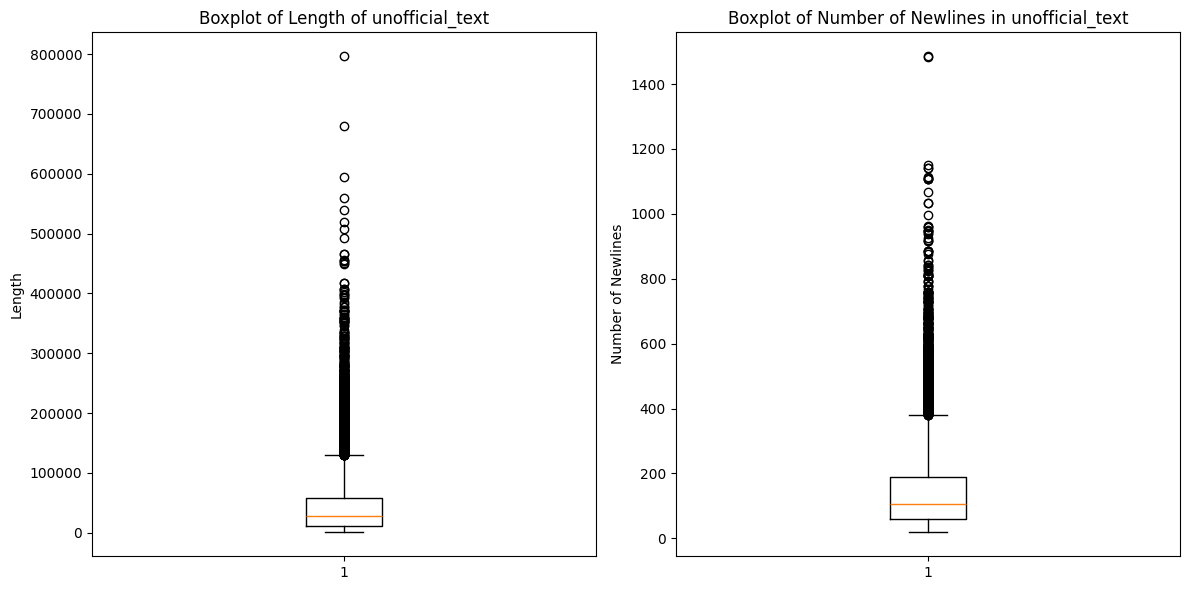

In [16]:
# prompt: boxplot of length of text in unofficial_text
# boxplot of number of \n in unofficial_text

import matplotlib.pyplot as plt

# Calculate the length of 'unofficial_text' for each row
df['unofficial_text_length'] = df['unofficial_text'].str.len()

# Calculate the number of newline characters in 'unofficial_text' for each row
df['unofficial_text_newlines'] = df['unofficial_text'].str.count(r'\n')

# Create a figure with two subplots (one for each boxplot)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot for the length of unofficial_text
axes[0].boxplot(df['unofficial_text_length'])
axes[0].set_title('Boxplot of Length of unofficial_text')
axes[0].set_ylabel('Length')

# Boxplot for the number of newline characters in unofficial_text
axes[1].boxplot(df['unofficial_text_newlines'])
axes[1].set_title('Boxplot of Number of Newlines in unofficial_text')
axes[1].set_ylabel('Number of Newlines')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


In [18]:
df_filtered = df[
    (df['unofficial_text_length'] <= 120000) &
    (df['language'] == 'en')
]

# Print the total number of rows left
print(f"Total rows left after filtering: {len(df_filtered)}")

Total rows left after filtering: 10108


In [19]:
import multiprocessing
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords

In [23]:
# 1. Build your stopword set once

stop_words = set(stopwords.words('english'))
stop_words |= {
    'from', 'subject', 're', 'edu', 'thereof', 'herein', 'hereby', 'aforesaid',
    'whereas', 'shall', 'henceforth', 'article', 'section'
    # Add more as needed
}

# 2. One-pass tokenization + stopword removal
def preprocess(doc):
    return [
        token for token
        in simple_preprocess(doc, deacc=True, min_len=3)
        if token not in stop_words
    ]

data_tokens = [preprocess(doc) for doc in df_filtered['unofficial_text']]

# 3. Build bigram phraser (skip trigram unless you really need it)
bigram = Phrases(data_tokens, min_count=10, threshold=50)  # tune min_count/threshold
bigram_mod = Phraser(bigram)
data_bigrams = [bigram_mod[doc] for doc in data_tokens]

# 4. Create & prune dictionary early
id2word = Dictionary(data_bigrams)
id2word.filter_extremes(
    no_below=15,     # drop tokens in fewer than 15 docs
    no_above=0.5,    # drop tokens in more than 50% of docs
    keep_n=10000     # keep only the top 10k tokens
)

# 5. Build corpus
corpus = [id2word.doc2bow(doc) for doc in data_bigrams]

# 6. Train LDA with multicore & tuned parameters
workers = max(1, multiprocessing.cpu_count() - 1)
lda_model = LdaMulticore(
    corpus=corpus,
    id2word=id2word,
    num_topics=25,
    random_state=1975,
    chunksize=20000,      # larger chunk → fewer Python callbacks
    passes=10,            # fewer full-corpus passes
    iterations=50,       # enough for convergence
    eval_every=None,     # disable perplexity eval (slow)
    workers=workers,
    alpha='asymmetric',  # faster convergence in many cases
    eta='auto',
    per_word_topics=False
)



# 7. (Optional) Compute coherence only on a sample
sample_texts = data_bigrams[:10000]
from gensim.models import CoherenceModel
cm = CoherenceModel(
    model=lda_model,
    texts=sample_texts,
    dictionary=id2word,
    coherence='c_v'
)
print('Coherence:', cm.get_coherence())

Coherence: 0.6204068967571778


In [22]:
print(lda_model.print_topics())


[(24, '0.007*"public" + 0.006*"para" + 0.006*"information" + 0.006*"charter" + 0.004*"canadian" + 0.004*"attorney_general" + 0.004*"ontario" + 0.003*"interest" + 0.003*"scc" + 0.003*"rights"'), (23, '0.008*"criminal" + 0.008*"crown" + 0.007*"child" + 0.006*"information" + 0.006*"jurisdiction" + 0.006*"criminal_code" + 0.005*"offence" + 0.005*"accused" + 0.005*"conviction" + 0.005*"charge"'), (22, '0.009*"city" + 0.005*"municipal" + 0.004*"statute" + 0.004*"legislation" + 0.004*"charter" + 0.004*"public" + 0.004*"power" + 0.003*"quebec" + 0.003*"land" + 0.003*"use"'), (21, '0.011*"province" + 0.010*"federal" + 0.009*"provincial" + 0.007*"parliament" + 0.007*"legislation" + 0.007*"power" + 0.006*"rights" + 0.006*"attorney_general" + 0.006*"government" + 0.005*"crown"'), (20, '0.029*"board" + 0.010*"jurisdiction" + 0.006*"union" + 0.006*"employees" + 0.005*"power" + 0.005*"employer" + 0.004*"collective_agreement" + 0.004*"labour" + 0.004*"employee" + 0.004*"authority"'), (19, '0.012*"prop

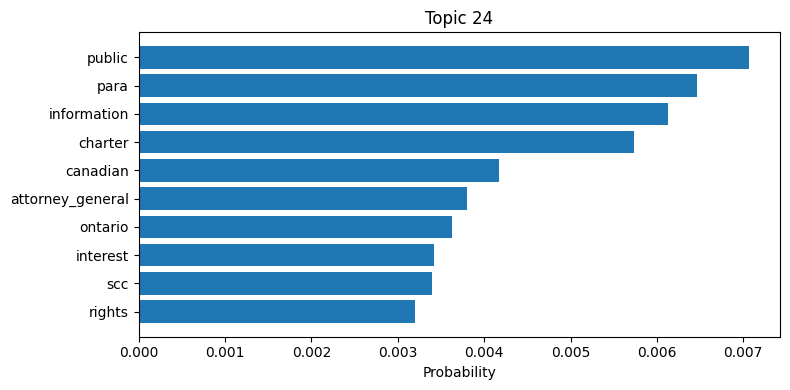

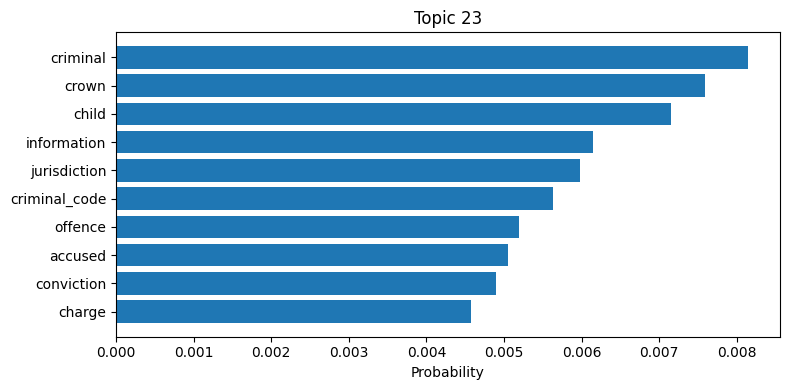

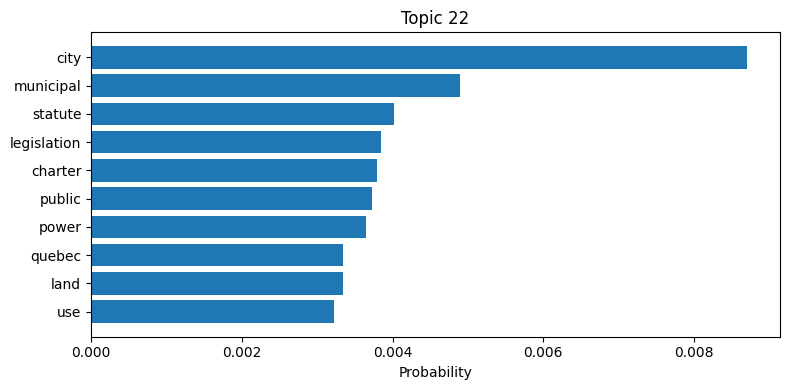

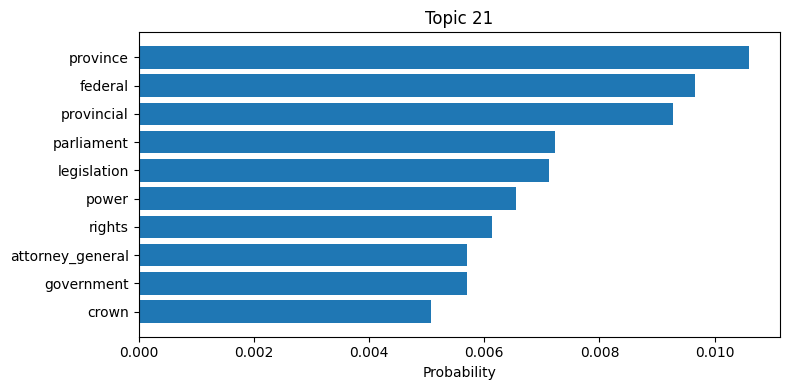

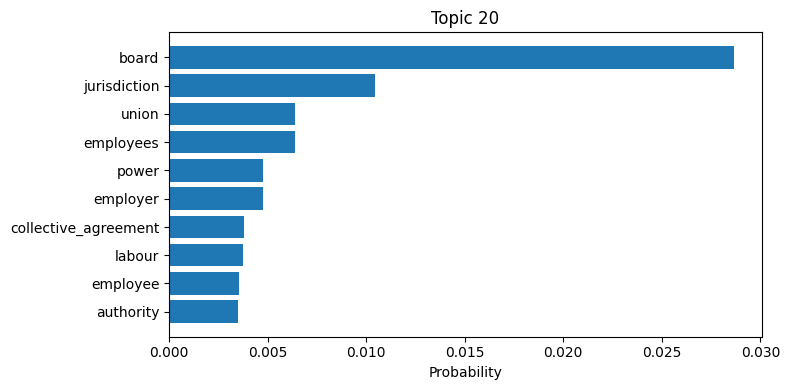

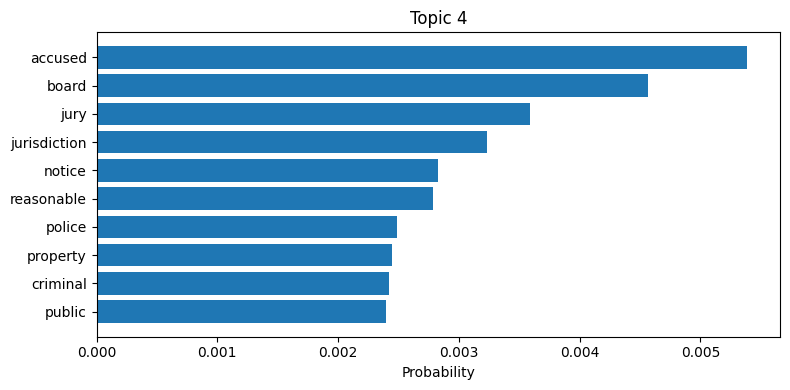

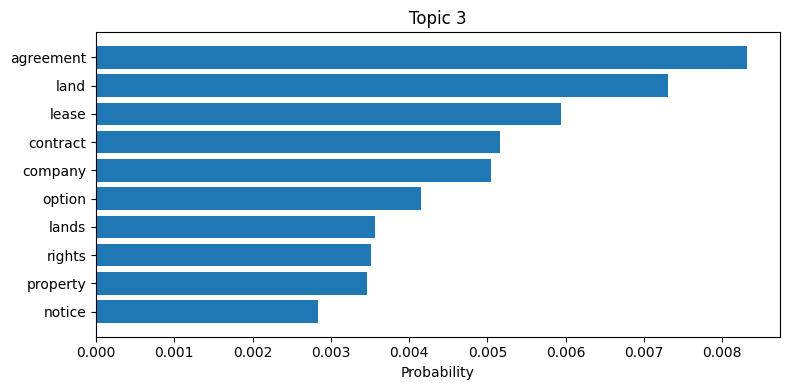

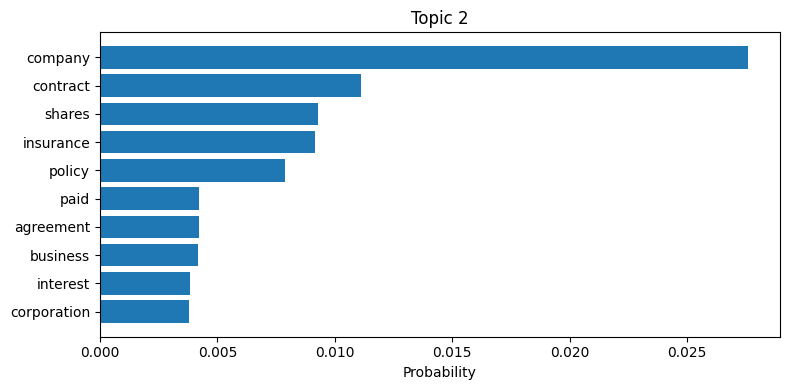

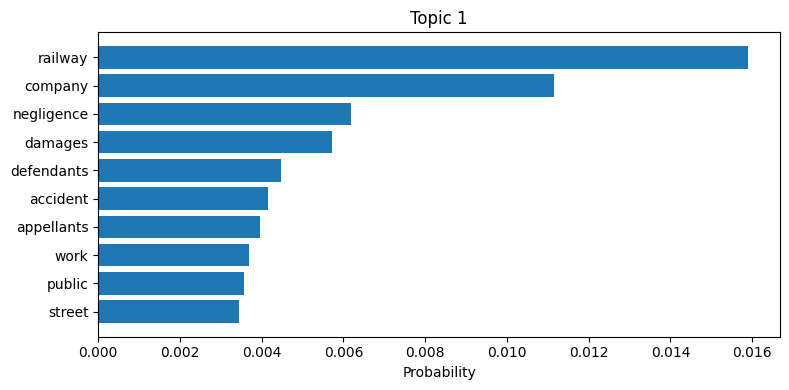

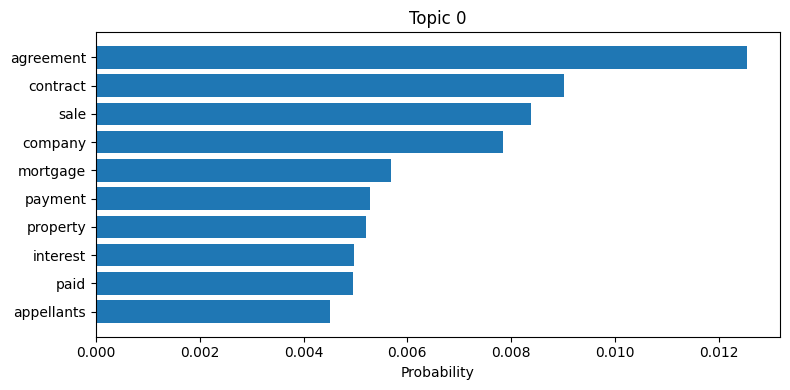

In [21]:
import matplotlib.pyplot as plt

def plot_top_words(lda_model, num_words=10):
    for i, topic in lda_model.show_topics(formatted=False, num_words=num_words):
        words, probs = zip(*topic)
        plt.figure(figsize=(8, 4))
        plt.barh(words, probs)
        plt.title(f'Topic {i}')
        plt.gca().invert_yaxis()
        plt.xlabel('Probability')
        plt.tight_layout()
        plt.show()

plot_top_words(lda_model, num_words=10)
